In [7]:
import pandas as pd
data = pd.read_csv('datasets/gender_classification.csv')
data[:10]

,long_hair,forehead_width_cm,forehead_height_cm,nose_wide,nose_long,lips_thin,distance_nose_to_lip_long,gender
0,1,11.8,6.1,1,0,1,1,Male
1,0,14.0,5.4,0,0,1,0,Female
2,0,11.8,6.3,1,1,1,1,Male
3,0,14.4,6.1,0,1,1,1,Male
4,1,13.5,5.9,0,0,0,0,Female
5,1,13.0,6.8,1,1,1,1,Male
6,1,15.3,6.2,1,1,1,0,Male
7,0,13.0,5.2,0,0,0,0,Female
8,1,11.9,5.4,1,0,1,1,Female
9,1,12.1,5.4,0,0,0,0,Female


In [3]:
data.isnull().any()
# 检查有无缺失值

long_hair                    False
forehead_width_cm            False
forehead_height_cm           False
nose_wide                    False
nose_long                    False
lips_thin                    False
distance_nose_to_lip_long    False
gender                       False
dtype: bool

In [4]:
data.describe()

,long_hair,forehead_width_cm,forehead_height_cm,nose_wide,nose_long,lips_thin,distance_nose_to_lip_long
count,5001.000000,5001.000000,5001.000000,5001.000000,5001.000000,5001.000000,5001.000000
mean,0.869626,13.181484,5.946311,0.493901,0.507898,0.493101,0.498900
std,0.336748,1.107128,0.541268,0.500013,0.499988,0.500002,0.500049
min,0.000000,11.400000,5.100000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,12.200000,5.500000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,13.100000,5.900000,0.000000,1.000000,0.000000,0.000000
75%,1.000000,14.000000,6.400000,1.000000,1.000000,1.000000,1.000000
max,1.000000,15.500000,7.100000,1.000000,1.000000,1.000000,1.000000


关于这个long_hair的特征，长头发占了大多数，而数据集样本分类是比较平均的，<br>
之前我想过把他去掉，不过后来对比了下去掉前后的模型，觉得还是保留为好, 这里就不写出过程了。<br>
下面来寻找合适的处理方法

In [29]:
from tool.preprocessing import Preprocessing
from tool.predict import Evaluation
import numpy as np
import matplotlib.pyplot as plt
from algorithm.LogisticRegression import LogisticRegression
plt.rcParams["font.sans-serif"] = ["SimHei"]

dataset = np.array(data)
prep = Preprocessing()
dataset = prep.LabelEncoder(dataset, [-1])

def show_ROC(data, ax, seed):
    """
    :description: 画出在不同的alpha值下的ROC曲线图
    :param data: 数据集
    :param ax: 子图
    :param seed: 划分训练集和测试集的随机种子
    :return: 在不同alpha和决策边界下，由准确率，决策边界，和alpha值组成的DataFrame
    """
    view = []
    # 遍历alpha
    for alpha in np.linspace(0.01, 4, 100):

        X_train, y_train, X_test, y_test = prep.split(data, seed=seed)
        LG = LogisticRegression(alpha=alpha)
        LG.fit(X_train, y_train)
        pred = Evaluation(X_test, LG.theta, y_test)
        TPR, FPR = pred.ROC()
        ax.plot(FPR, TPR)

        for threshold in np.linspace(0., 1., 200):
            view.append([pred.accuracy(threshold), threshold, alpha])

    ax.set_xlabel('FPR', fontsize=30)
    ax.set_ylabel('TPR', fontsize=30)
    view = pd.DataFrame(view, columns=['accuracy', 'threshold', 'alpha']).sort_values('accuracy', ascending=False)

    return view


在这里对比下对forehead_width_cm和forehead_height_cm列的的数据进行无量纲化的两种方法

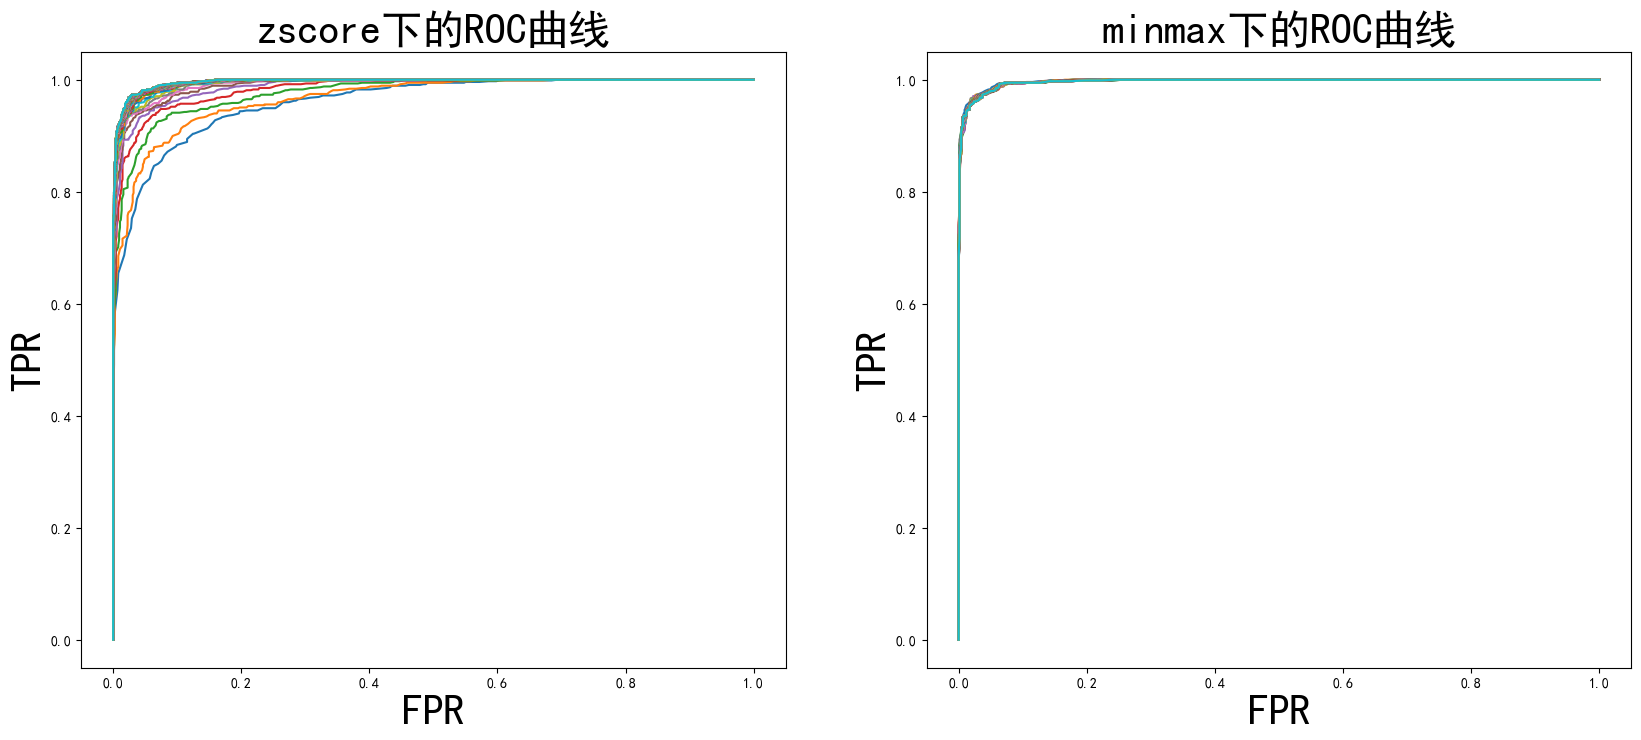

       accuracy  threshold     alpha
19315  0.972019   0.577889  3.879091
15104  0.972019   0.522613  3.032727
19501  0.972019   0.507538  3.919394
14915  0.972019   0.577889  2.992424
17715  0.972019   0.577889  3.556667
17714  0.972019   0.572864  3.556667
17708  0.972019   0.542714  3.556667
15103  0.972019   0.517588  3.032727
15105  0.972019   0.527638  3.032727
19503  0.972019   0.517588  3.919394
准确率前20的决策边界的平均值 0.5412060301507537
      accuracy  threshold     alpha
910   0.974017   0.552764  0.171212
1509  0.974017   0.547739  0.292121
326   0.973351   0.633166  0.050303
518   0.973351   0.592965  0.090606
712   0.973351   0.562814  0.130909
713   0.973351   0.567839  0.130909
1309  0.973351   0.547739  0.251818
1110  0.973351   0.552764  0.211515
329   0.973351   0.648241  0.050303
911   0.972685   0.557789  0.171212
准确率前20的决策边界的平均值 0.5728643216080402


In [51]:
fig = plt.figure(figsize=(20, 8))

# 为了做对比，在同一个种子下进行
seed = np.random.randint(10000)

# zscore处理
data =  prep.zscore(dataset, [1, 2])
ax1 = fig.add_subplot(1, 2, 1)
view1 = show_ROC(data, ax1, seed)
ax1.set_title('zscore下的ROC曲线', fontsize=30)

# 归一处理
data =  prep.minmax(dataset, [1, 2])
ax2 = fig.add_subplot(1, 2, 2)
view2 = show_ROC(data, ax2, seed)
ax2.set_title('minmax下的ROC曲线', fontsize=30)

plt.show()
print(view1[:10])
print("准确率前20的决策边界的平均值", (view1.iloc[:20, 1]).mean())
print(view2[:10])
print("准确率前20的决策边界的平均值", (view2.iloc[:20, 1]).mean())

很明显可以看到，虽然两种方法最佳的ROC曲线几乎一样，但经过minmax归一化的模型的ROC曲线受alpha影响更小，<br>
而从view的数据来看，准确率考前的模型，alpha的值波动较大，<br>
再综合minmax归一的模型准确率较高，所以数据处理的方式选择minmax归一化最佳<br>
准确率高的模型决策边界波动较小，取它们的平均值0.57, 再运行几次，<br>
alpha就取0.5吧..